**Considerations**:
- This Jupiter Notebook was made by José Maria Trindade, student of MBDS from BTS, with the help of Chat GPT. Big thanks to my colleague Daniel that cleared questions I had during the process.

## Record Linkage 
    
    
Let's consider that you, as a data scientist, are working for **Retailer A**, a large-scale department store chain. Retailer A has recently entered into a strategic partnership with **Retailer B**, an online e-commerce platform specializing in products. As part of this partnership, Retailer B has shared its product descriptions dataset with Retailer A for the purpose of cross-promotion, product indexing and targeted marketing.

Your task is to perform **entity resolution**, also known as record linkage, on these datasets. The goal is to identify which products in Retailer B's dataset are also products of Retailer A. This will allow the marketing department to create more personalized product offering campaigns and product indexes.

Entity resolution can be a complex task due to various reasons such as data inconsistencies, missing values, and the need to protect customer privacy. It involves several steps including data cleaning, data standardization, and matching records.

You may find the datasets in CSV format:

    - retailerA.csv
    - retailerB.csv 

In [1]:
import time
start_time = time.time()

# Loading data
import pandas as pd

# Tokenization and data prep
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt') # punctuation words
nltk.download('stopwords') # stop words

# Entity matching (similarity matrix)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Entity Clustering

import hdbscan # clustering algorithm
from sklearn.decomposition import PCA # dimension reduction
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting toolkit
import numpy as np # for testing
import matplotlib.pyplot as plt

end_time = time.time()
import_time = end_time - start_time
print(f"Libraries Import Time: {import_time} seconds")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zemariatrindade/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zemariatrindade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Libraries Import Time: 4.995297193527222 seconds


### Exploratory Data Analysis and Preparation

In this section, I'm going to get an overview of the datasets we are working with, and evaluate what's the best strategy to cluster products across retailers.

In [2]:
def loadData(csv1_name, csv2_name):
        
        retailerA = pd.read_csv("retailerA.csv")
        retailerB = pd.read_csv("retailerB.csv")

        return retailerA, retailerB

In [6]:
start_time = time.time()

retailerA, retailerB = loadData("retailerA.csv","retailerB.csv")

end_time = time.time()
print(f"Data Loading Time: {end_time - start_time} seconds")

Data Loading Time: 0.018125057220458984 seconds


In [4]:
# Checking the number of products for retailerA
retailerA.info() # There are 1081 entries, but the price column only has 418 entries.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   unique_id    1081 non-null   int64 
 1   title        1081 non-null   object
 2   description  1081 non-null   object
 3   price        418 non-null    object
dtypes: int64(1), object(3)
memory usage: 33.9+ KB


In [6]:
# Checking the number of products for retailerB
retailerB.info() # There are 1092 entries for title attribute, but only 646 and 590 for description and price attributes, respectively.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   unique_id    1092 non-null   int64 
 1   title        1092 non-null   object
 2   description  646 non-null    object
 3   price        590 non-null    object
dtypes: int64(1), object(3)
memory usage: 34.3+ KB


- At this point, we can say that we will do the entity resolution and clustering to the title atributte given that is the one that can use the most records in each retailer, unless there is a significant amount of duplicates and NaN values.

In [7]:
# Let's check if there are duplicates in the title attribute for retailerA
retailerA[retailerA["title"].duplicated()]

,unique_id,title,description,price


In [28]:
# Let's check if there are duplicates in the title attribute for retailerB
retailerB[retailerB["title"].duplicated()] # we have some cases.

,unique_id,title,description,price,Cluster ID
412,403,Peerless SmartMount 700 Series Articulating Wa...,Peerless SA750PU - Articulating Wall Arm for 3...,NaN,196
456,445,The LG Electric SteamDryer,NaN,NaN,124
768,755,LG 25.0 Cu.Ft. Total Capacity,NaN,NaN,135
769,756,LG 25.0 Cu.Ft. Total Capacity,NaN,NaN,135
770,757,LG 25.0 Cu.Ft. Total Capacity,NaN,NaN,135
783,770,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN,143
784,771,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN,143
785,772,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN,143
786,773,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN,143
788,775,LG 5.0 cu.ft. Freestanding Gas Range,NaN,NaN,142


We could drop duplicates here, but it seems that there is no repition of unique IDs and therefore would be dangerours to delete any records.

In [9]:
# Let's check for NaN values for retailerA
retailerA[retailerA["title"].isna()] # there seems to be no NaN values in the title attribute

,unique_id,title,description,price


In [10]:
# Let's check for NaN values for retailerB
retailerB[retailerB["title"].isna()] # there seems to be no NaN values in the title attribute

,unique_id,title,description,price


In [11]:
print("Number of title records for retailer A:",retailerA["title"].value_counts().sum())
print("Number of title records for retailer B:",retailerB["title"].value_counts().sum())

Number of title records for retailer A: 1081
Number of title records for retailer B: 1092


**Conclusion**: As a result of this analysis, we will apply the entity resolution to the title attribute of both retailers.

### Entity resolution

Data stored in information systems are often erroneous. The
most typical errors include: inconsistent, missing, and outdated
values, typos as well as duplicates. To handle data of poor quality,
data cleaning (a.k.a. curation) and deduplication (a.k.a. entity
resolution) methods are used in projects realized by research
and industry. This is of particular challenge due
to its computational complexity and the complexity of finding
the most adequate method for comparing records and computing
similarities of these records. The similarity value of two records
is a compound value, whose computation is based on similarities
of individual attribute values.


Recall that an ER pipeline includes four basic tasks, namely:
    
- Blocking (a.k.a. indexing) - it organizes records into groups,
such that each group includes records that may include
potential duplicates.

- Block processing (a.k.a. filtering) - its goal is to eliminate
records that do not have to be compared.

- **Entity matching** (a.k.a. similarity computation) - it computes similarity values between records compared in pairs,
i.e., a value of each attribute in one record is compared to
a value of a corresponding attribute in the second record.

- **Entity clustering** - it aims at creating groups of similar records, from pairs of records representing highly probable duplicates.


For simplicity, we are going to focus on entity matching and entity clustering. This is a fairly basic pipeline and it can be extended in many ways. For example, sophisticated pre-processing and matching algorithms can be used. Or thinking about how to scale the entity resolution (i.e. speeding up the process without sacrificying accuracy).

Paper about Entity Resolution (ER): https://ceur-ws.org/Vol-3369/paper3.pdf


## Step 1: Data cleaning

Perform data cleaning with the help of regex expressions, removal of stopwords and the tokenization of the documents/sentences or paragraphs. Things like casing, extra spaces, quotes and new lines can be ignored (not limited to that though).

spaCy provides a one-stop-shop for tasks commonly used in any NLP project, so they might have all these functionalities. It useful to explore other packages like NTLK, or build the cleaning steps yourself.


The recommended workflow is the following: Read in the CSV files and apply the data cleaning operations.

***Hint***: https://www.nltk.org/api/nltk.tokenize.html

1. We will use a combined list with all the titles of products from both retailers
2. In this exercise, I'm going to use the package NLTK tokenizer.

**ChatGPT 3.5**

- If our goal is to tokenize titles and you are looking for a lightweight solution, the NLTK (Natural Language Toolkit) library is a good option. NLTK is known for its simplicity and ease of use, and it provides a variety of tokenizers.

In [32]:
def tokenizeData(df1,df2):
   
    # Combining titles of retailer A and B in a single list
    titles = df1["title"].tolist() + df2["title"].tolist()

    # Getting the total number of records of retailerA so we can later split the list in two
    nr_of_docs_A = len(df1["title"])
    
    # Get English stop words and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    
    # Tokenizing the list of sentences ("titles")
    tokenized_titles = [
        [word.lower() for word in word_tokenize(title) 
         if word.lower() not in stop_words and word.lower() not in punctuation] for title in titles]

    return tokenized_titles, nr_of_docs_A

In [33]:
start_time = time.time()
tokenized_titles, nr_of_docs_A = tokenizeData(retailerA, retailerB)
end_time = time.time()
print(f"Cleaning Time: {end_time - start_time} seconds")

Cleaning Time: 0.24016594886779785 seconds


## Step 2: Entity Matching

For every product record in the retailer A, we need to compute its similarity to every record in retailer B- Think about the total number of comparisons you need to perform.

A very simple approach would be to use rule matching based on matches from regular expressions. Very powerful techniques can also arise from fuzzy matching and string distance algorithms. One could also try, for example, computing text similarity among sentences/documents/paragraphs using different model or feature extractors, and then compute similarities based on vector distances (i.e. cosine,euclidean,jaccard ) similarity. You may use the following model (not restricted to though):

- **Bag of Words (BoW)** Scikit-Learn, NTLK
- **N-grams**: Scikit-Learn, NTLK
- **TF-IDF**: Scikit-Learn, NTLK
- **Word embedding models**: Word2Vec ( Spacy, Gensim are packages that have this functionality)
- **Pre-trained language models**: BERT and large language models

**Extra**: There are ways to avoid this large number of comparisons among entities, they involve sophisticated methods like inserting blocking pipelines. Research this area, only after you have completed all the steps, and as an. You can opt to save the intermediary files (i.e. pairwise similarity matrix) to disk to avoid computing this step every single time. There are also additional open source libraries in python that you may use for the end-to-end entity resolution or parts of it, exclusively dedicated  to ER: *RecordLinkage*, *dedupe*, *Zingg*.

In [34]:
def computeSimilarity(tokenized_titles, nr_of_docs_A):
    
    # Convert tokenized titles back to strings for TF-IDF
    document_texts = [' '.join(tokens) for tokens in tokenized_titles]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(document_texts)

    # At this point there is a long matrix with records being the products and features being tokens 
    
    # Cosine Similarity Matrix between the 2 sets of products combined
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim_matrix, nr_of_docs_A

In [35]:
start_time = time.time()
cosine_sim_matrix, nr_of_docs_A = computeSimilarity(tokenized_titles, nr_of_docs_A)
end_time = time.time()
print(f"Matching Time: {end_time - start_time} seconds")

Matching Time: 0.5804259777069092 seconds


In [38]:
# Visualize Cosine similarity in a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index = retailerA["title"].tolist()+retailerB["title"].tolist(), columns = retailerA["title"].tolist()+retailerB["title"].tolist())
cosine_sim_df.head()

,Linksys EtherFast 8-Port 10/100 Switch - EZXS88W,Linksys EtherFast10/100 5-Port Auto-Sensing Switch - EZXS55W,Netgear ProSafe 5 Port 10/100 Desktop Switch - FS105,Belkin F3H982-10 Pro Series High Integrity 10 Feet Monitor Cable - F3H98210,Netgear Prosafe 16 Port 10/100 Rackmount Switch - Black Finish - JFS516NA,LaCie USB 2.0 Floppy Disk Drive - 706018,Canon KP-36IP Color Ink & Paper Set - 7737A001,Kensington Orbit Optical Trackball Mouse - 64327,Linksys EtherFast4116 16-Port 10/100 Ethernet Switch - EF4116,Linksys EtherFast 4124 24-Port Ethernet Switch - EF4124,...,Garmin 010-00577-30 Nvi(r) 885t Travel Assistant,Samsung LN32A450 32' 720p LCD HDTV,Maytag MDB7851AWB Full Console Dishwasher (Black),Whirlpool DU1100XTPS 24' Undercounter Dishwasher (Stainless Steel),Canon XH A1S - 3238B001,Sony VAIO FW378J/B Notebook - VGNFW378J/B,Sennheiser CX380 Sennheiser CX 380 Sport II Grey/Orange,IWORK 09 RETAIL-INT DVD - MB942Z/A,IWORK 09 FAMILY PACK-INT DVD - MB943Z/A,CASE MATE CARBON FIBER IPHONE 3G CASE BLACK - IPH3GC-BCF
Linksys EtherFast 8-Port 10/100 Switch - EZXS88W,1.000000,0.410289,0.459142,0.137132,0.390311,0.0,0.0,0.0,0.495500,0.468783,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Linksys EtherFast10/100 5-Port Auto-Sensing Switch - EZXS55W,0.410289,1.000000,0.309092,0.000000,0.262755,0.0,0.0,0.0,0.347357,0.255868,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Netgear ProSafe 5 Port 10/100 Desktop Switch - FS105,0.459142,0.309092,1.000000,0.129625,0.576691,0.0,0.0,0.0,0.388717,0.205163,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Belkin F3H982-10 Pro Series High Integrity 10 Feet Monitor Cable - F3H98210,0.137132,0.000000,0.129625,1.000000,0.110192,0.0,0.0,0.0,0.116098,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Netgear Prosafe 16 Port 10/100 Rackmount Switch - Black Finish - JFS516NA,0.390311,0.262755,0.576691,0.110192,1.000000,0.0,0.0,0.0,0.454882,0.174407,...,0.0,0.0,0.020831,0.0,0.0,0.0,0.0,0.0,0.0,0.015224


## Step 3: Entity clustering

Once entities have been resolved as matches. we need to  merge them in order to produce a single representative record. This involves grouping the entities based on the similarity scores. Entities or records in the same cluster are considered to be the same.

*Hint: You can use different clustering algorithms from the [sklearn-clustering](https://scikit-learn.org/stable/modules/clustering.html) library*



**Choosing the algorithim**

In order to perform Entity Clustering, we are going to use the **HDBSCAN** (Hierarchical Density-Based Spatial Clustering of Applications with Noise).

Given that we want to explore clusters in high-dimensional space, we preferably need a algorithm that can identify clusters of arbitrary shapes, while automatically determining the number of clusters.

**Chat GPT 3.5:** HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is typically designed to work with a distance or dissimilarity matrix rather than a similarity matrix. This means that when using HDBSCAN, you would often need to transform your cosine similarity matrix into a dissimilarity matrix.

HDBSCAN works with the concept of mutual reachability distance, which is a form of dissimilarity. The common practice is to subtract the similarity values from 1 to obtain dissimilarity values. Therefore, **transforming your cosine similarity matrix to a dissimilarity matrix (e.g., 1 - cosine_similarity_matrix) is a common step when applying HDBSCAN.**

In [37]:
def generateClusters(cosine_sim_matrix, nr_of_docs_A):
    
    # Transform to dissimilarity matrix
    dissimilarity_matrix = 1 - cosine_sim_matrix

    # Use HDBSCAN with transformed dissimilarity matrix
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='precomputed',gen_min_span_tree=True ).fit(dissimilarity_matrix)
    clusters = clusterer.labels_
    
    # Use PCA for dimensionality reduction
    pca = PCA(n_components=3)
    reduced_data_to_plot = pca.fit_transform(cosine_sim_matrix)
    
    # Assign the cluster labels to retailerA df as "Cluster ID"
    retailerA["Cluster ID"] = clusters[:nr_of_docs_A]
    
    # Assign the cluster labels to retailerB df as "Cluster ID"
    retailerB["Cluster ID"] = clusters[nr_of_docs_A:]
    
    return clusters, reduced_data_to_plot, pca

In [16]:
start_time = time.time()
clusters, reduced_data_to_plot, pca = generateClusters(cosine_sim_matrix, nr_of_docs_A)
end_time = time.time()
print(f"Clustering Time: {end_time - start_time} seconds")

Clustering Time: 1.5524559020996094 seconds


#### Visualization

To visualize the entity clustering, we will use Dimensionality Reduction Techniques like PCA (Principal Component Analysis) to reduce the number of features to 3 dimensions.

- **2-D Representation**

In [18]:
def visualize2D(clusters,reduced_data_to_plot):
    
    for cluster in range(max(set(clusters))):
        cluster_points = reduced_data_to_plot[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')

    plt.title('HDBSCAN Clustering Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

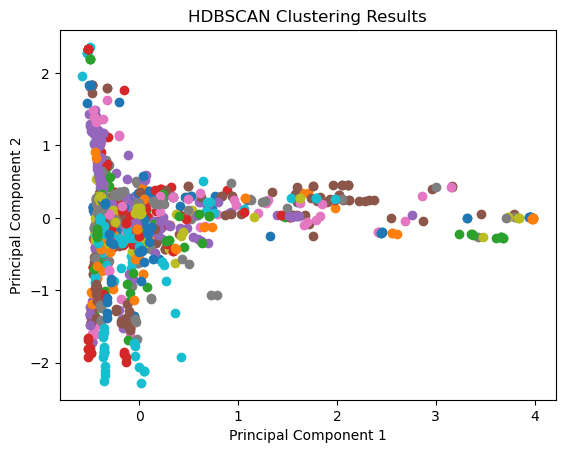

2D Visualization Time: 3.6285250186920166 seconds


In [20]:
start_time = time.time()
visualize2D(clusters,reduced_data_to_plot)
end_time = time.time()
print(f"2D Visualization Time: {end_time - start_time} seconds")

- **3-D Representation**

In [25]:
def visualize3D(clusters,reduced_data_to_plot):   
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in range(max(set(clusters))):
        cluster_points = reduced_data_to_plot[clusters == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster + 1}')

    ax.set_title('HDBSCAN Clustering Results (3D)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

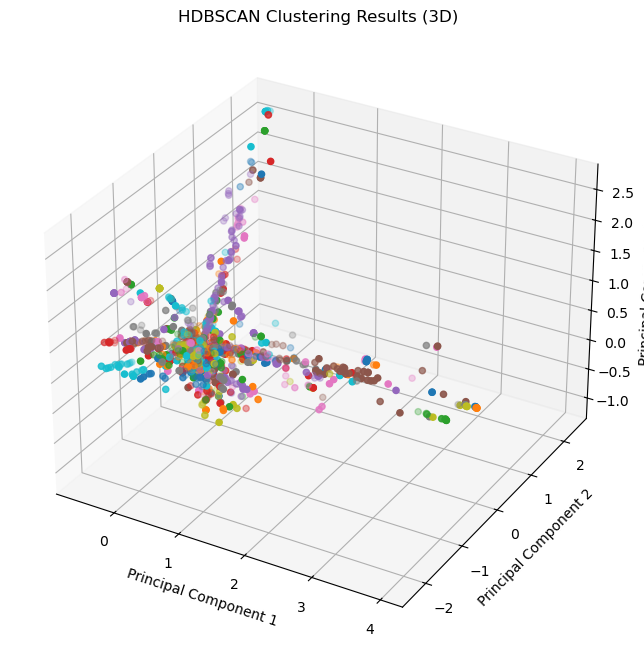

3D Visualization Time: 2.327138662338257 seconds


In [27]:
start_time = time.time()
visualize3D(clusters,reduced_data_to_plot)
end_time = time.time()
print(f"3D Visualization Time: {end_time - start_time} seconds")

- **Tabular Visualization**

Retailer A df sorted by Cluster ID (from 1 to 4 included)

In [28]:
retailerA[(retailerA["Cluster ID"]>0) & (retailerA["Cluster ID"]<5)].sort_values("Cluster ID")

,unique_id,title,description,price,Cluster ID
274,273,Panasonic Silver Rice Cooker/Warmer - SRTMB10,Panasonic Silver Rice Cooker/Warmer - SRTMB10/...,NaN,1
311,310,Panasonic SR-NA18 White Deluxe Fuzzy Logic Ric...,Panasonic SR-NA18 White Deluxe Fuzzy Logic Ric...,NaN,1
112,112,Kensington MicroSaver Keyed Notebook Lock - 64...,Kensington MicroSaver Keyed Notebook Lock - 64...,NaN,2
355,354,Kensington Combosaver Ultra Combination Notebo...,Kensington Combosaver Ultra Combination Notebo...,$39.00,2
266,265,Oregon Scientific AT18 Wearable Waterproof Act...,Oregon Scientific AT18 Wearable Waterproof Act...,NaN,3
1014,1010,Twenty20 VholdR Mount Adhesive - 2200MA,Twenty20 VholdR Mount Adhesive - 2200MA/ Remov...,$6.00,3
1028,1024,Twenty20 VholdR Wearable Camcorder Bundle - 1102,Twenty20 VholdR Wearable Camcorder Bundle - 11...,NaN,3
138,138,Fellowes Confetti Cut Shredder - W11C,Fellowes Confetti Cut Shredder - W11C/ Shreds ...,$79.00,4
258,257,Fellowes MicroShred Shredder - MS450CS,Fellowes MS-450CS MicroShred Shredder - MS450C...,$189.00,4
259,258,Fellowes Personal Powershred Shredder - SB97CS,Fellowes Personal Powershred Shredder - SB97CS...,NaN,4


#### Testing the algorithm
To test the amount of cumulative explained variance captured by the model we runned the following test. One can say that we might have to increase the number of components in order to get a higher cum explained variance.

In [24]:
def testAlgorithm(pca):
    # Get the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Get the cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Print the cumulative explained variance
    print("Cumulative Explained Variance with 3 components:")
    print(cumulative_variance)

In [25]:
testAlgorithm(pca)

Cumulative Explained Variance with 3 components:
[0.12243246 0.18899022 0.24055199]


## Step 4: Writing Results


Write our original data (retailer A) back out to a CSV with a new column called ‘Cluster ID’ which indicate which records from retailer B (specified by their unique ids column) are matched to records from retailer A. Evaluate whether results are making sense by visually inspecting the dataset. You can use evaluation metrics with a groundtruth database (it will be provided later on). Your performance will be recorded.

**Extra**: You can also profile the end-to-end pipeline and record the time it takes to perform this task, argue how well your approach scales, maybe even plot running time as the number of records in the retailer´s databases  grows.


In [26]:
def writeDataToDisk(output_filename):
    # TO-DO
    
    if output_filename == "RetailerA_updated.csv":
        # Saving the updated retailerA df back to csv file
        retailerA.to_csv("RetailerA_updated.csv")

    elif output_filename == "RetailerB_updated.csv":
        # Saving the updated retailerB df back to csv file
        retailerB.to_csv("RetailerB_updated.csv")    
    else:
        print("File not available")

In [27]:
# Only run this cell, if the files are not yet in your directory
writeDataToDisk("RetailerA_updated.csv")
writeDataToDisk("RetailerB_updated.csv")

### Extras

#### Entity Blocking (a.k.a indexing):

(with Chat GPT 3.5) I conducted some research and I found that, specially in our special case, blocking is not strictly necessary for every entity resolution task, especially with a smaller dataset like ours.
With a dataset of 2,000 records, the scale might be manageable for direct comparison without blocking, especially if the computational resources are sufficient.

#### End-to-end Pipeline

In this section we will train all the steps in one instance and track the time it took to go end-to-end in the pipeline.

If you got to this stage and you want to skip all the steps, you can just run the 2nd cell (import libraries) and the next 2 cells of this notebook to get a end-to-end view of the pipeline.

In [2]:
# Functions composing the whole Pipeline in one place

start_time = time.time()

def loadData(csv1_name, csv2_name):
    
        retailerA = pd.read_csv("retailerA.csv")
        retailerB = pd.read_csv("retailerB.csv")

        return retailerA, retailerB
    
def tokenizeData(df1,df2):
   
    # Combining titles of retailer A and B in a single list
    titles = df1["title"].tolist() + df2["title"].tolist()

    # Getting the total number of records of retailerA so we can later split the list in two
    nr_of_docs_A = len(df1["title"])
    
    # Get English stop words and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    
    # Tokenizing the list of sentences ("titles")
    tokenized_titles = [
        [word.lower() for word in word_tokenize(title) 
         if word.lower() not in stop_words and word.lower() not in punctuation] for title in titles]

    return tokenized_titles, nr_of_docs_A

def computeSimilarity(tokenized_titles, nr_of_docs_A):
    
    # Convert tokenized titles back to strings for TF-IDF
    document_texts = [' '.join(tokens) for tokens in tokenized_titles]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(document_texts)

    # At this point there is a long matrix with records being the products and features being tokens 
    
    # Cosine Similarity Matrix between the 2 sets of products combined
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim_matrix, nr_of_docs_A

def generateClusters(cosine_sim_matrix, nr_of_docs_A):
    
    # Transform to dissimilarity matrix
    dissimilarity_matrix = 1 - cosine_sim_matrix

    # Use HDBSCAN with transformed dissimilarity matrix
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='precomputed',gen_min_span_tree=True ).fit(dissimilarity_matrix)
    clusters = clusterer.labels_
    
    # Use PCA for dimensionality reduction
    pca = PCA(n_components=3)
    reduced_data_to_plot = pca.fit_transform(cosine_sim_matrix)
    
    # Assign the cluster labels to retailerA df as "Cluster ID"
    retailerA["Cluster ID"] = clusters[:nr_of_docs_A]
    
    # Assign the cluster labels to retailerB df as "Cluster ID"
    retailerB["Cluster ID"] = clusters[nr_of_docs_A:]
    
    return clusters, reduced_data_to_plot, pca

In [3]:
retailerA, retailerB = loadData("retailerA.csv","retailerB.csv")
clusters, reduced_data_to_plot, pca = generateClusters(*computeSimilarity
                                                           (*tokenizeData(*loadData("retailerA.csv","retailerB.csv"))))

end_time = time.time()
pipeline_time = end_time - start_time 

print(f"Import Time: {import_time} seconds")
print(f"Pipeline Time: {pipeline_time} seconds")
print(f"End-to-end Pipeline Time: {import_time + pipeline_time} seconds")


Import Time: 4.995297193527222 seconds
Pipeline Time: 3.1770660877227783 seconds
End-to-end Pipeline Time: 8.17236328125 seconds
